In [1]:
import os
import glob
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
# numpy's lnorm is equivalent to scipy.spatial.distance.euclidean (I checked), but faster. 
from numpy.linalg import norm as lnorm
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('ticks')

# Lihui's behavioral data

Inspect one of the subject's results for better understanding.

In [3]:
datadir = '/Users/Oliver/Desktop/Lihui_Data/RI/Exp2'

In [4]:
test_data = pd.read_hdf(pjoin(datadir, 'sub-001_ver1_sess1_Naming.hdf'))
test_data.head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum
0,stim_set/Loeffel.6_v2_percept.png,Löffel,"[Schere, Zahnpasta, Glas]",0,3,2.481411,"[-0.4635416666666667, -0.2111111111111111]",0,0
1,stim_set/Glas.3_v2_percept.png,Glas,"[Schere, Tasse, Flasche]",0,99,0.000000,"[-0.39375, -0.24444444444444444]",0,1
2,stim_set/Flasche.2_v2_percept.png,Flasche,"[Tasse, Banane, Schere]",0,99,0.000000,"[-0.5552083333333333, -0.23148148148148148]",0,2
3,stim_set/Flasche.3_v2_percept.png,Flasche,"[Glas, Schere, Apfel]",0,3,2.212549,"[0.5010416666666667, -0.22037037037037038]",0,3
4,stim_set/Schere.2_v2_percept.png,Schere,"[Zahnpasta, Flasche, Glas]",0,3,2.833762,"[-0.22291666666666668, -0.22407407407407406]",0,4


Take the results from the second experiment, naming task.

# Compute Euclidean Distance between original and simulation

In [5]:
def comp_ed(sim_hmax, orig_hmax):
    """
    Read HMAX output files for simulated and original image with pandas.
    Compute Euclidean distance between the two.
    Return dict with ED, as well as file paths.
    """
    # simulated
    sim_df = pd.read_csv(sim_hmax, header=None)
    assert np.shape(sim_df[0]) == (2000,)

    # original
    orig_df = pd.read_csv(orig_hmax, header=None)
    assert np.shape(orig_df[0]) == (2000,)

    # compute euclidean distance
    ed = lnorm(sim_df[0]-orig_df[0])
    
    # get path names of pictures
    orig_pname = orig_hmax.replace('.ascii', '').replace('./results/', '')
    sim_pname = sim_hmax.replace('.ascii', '').replace('./results/', '')
    
    # return dict
    ed_dict = {
        'ed' : ed,
        'orig' : orig_pname,
        'sim' : sim_pname
    }
    return ed_dict

In [6]:
# Example

ed_dict = comp_ed(sim_hmax='./results/Apfel.1_v2_percept.png.ascii',
             orig_hmax='./results/Apfel.1_v1_new.jpg.ascii')

print(ed_dict)

{'ed': 8.966686528324578, 'sim': 'Apfel.1_v2_percept.png', 'orig': 'Apfel.1_v1_new.jpg'}


## Collect EDs for all relevant stimuli

In [7]:
# how many HMAX outputs have we?
# Should be 144 (80 originals + 64 simulations used by Lihui)
assert len(glob.glob('./results/*')) == 144

In [8]:
# My HMAX output
sim_flist = glob.glob('./results/*')
sim_flist.sort()
# sim_flist

In [9]:
# Names of Lihui's stimuli without file extension
picnames = [pathname.split('/')[-1].replace('_v2_percept.png','') for pathname in test_data.Img.unique()]
#picnames

In [10]:
# iterate through all relevant stimuli

# list of dicts to be filled
ed_dicts = []

for picname in picnames:
    # paths to hmax results
    orig_hmax = './results/' + picname + '_v1_new.jpg.ascii'
    sim_hmax = './results/' + picname + '_v2_percept.png.ascii'
    # ed
    ed_dict = comp_ed(sim_hmax, orig_hmax)
    ed_dicts.append(ed_dict)

assert len(ed_dicts) == 64

## Descriptive statistics

In [11]:
# only the distances
eds = [ed_dict['ed'] for ed_dict in ed_dicts]

In [12]:
print('mean ED: %f' % np.mean(eds))
print('standard deviation: %f' % np.std(eds))

mean ED: 15.477273
standard deviation: 1.607819


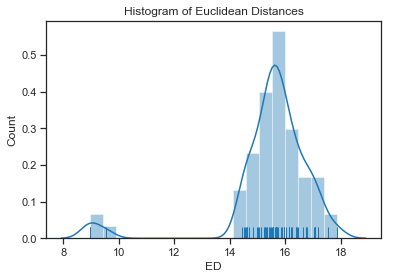

In [13]:
sns.distplot(eds, rug=True)

plt.title('Histogram of Euclidean Distances')
plt.xlabel('ED')
plt.ylabel('Count')

**Note:**
- Euclidean distances are not normally distributed due to some outliers with low values (these could be apples)
- Besides that, there seems to be enough variability in the EDs to use for prediction

## Find the outliers

In [14]:
sorted_ed_dicts = sorted(ed_dicts, key=lambda k: k['ed']) 

In [15]:
sorted_ed_dicts[:5]

[{'ed': 8.941344299468149,
  'orig': 'Apfel.2_v1_new.jpg',
  'sim': 'Apfel.2_v2_percept.png'},
 {'ed': 8.966686528324578,
  'orig': 'Apfel.1_v1_new.jpg',
  'sim': 'Apfel.1_v2_percept.png'},
 {'ed': 9.52822620953396,
  'orig': 'Apfel.3_v1_new.jpg',
  'sim': 'Apfel.3_v2_percept.png'},
 {'ed': 14.448208366549999,
  'orig': 'Apfel.7_v1_new.jpg',
  'sim': 'Apfel.7_v2_percept.png'},
 {'ed': 14.517777719989972,
  'orig': 'Loeffel.6_v1_new.jpg',
  'sim': 'Loeffel.6_v2_percept.png'}]

The three outliers are indeed some of the apples.

# Add ED to behavioral data
(as well as subject number)

We want to start with the results from experiment 2, naming task only, which are represented in hdf files.

In [16]:
# Show content of data directory

#sorted(glob.glob(datadir+'/*'))

# There's 32 subjects (subject 9 is missing).
# Each has 2 files: one for naming and one for discrimination task.

In [17]:
# Get list of file names for naming task only
hdf_files = sorted(glob.glob(datadir+'/*Naming*'))
assert len(hdf_files) == 32

In [18]:
# Read all files in pandas
behav_dfs = [pd.read_hdf(hdf_file) for hdf_file in hdf_files]

In [19]:
def insert_eds(df, ed_dicts):
    """
    Insert euclidean distances into a Data Frame.
    """
    # construct new list of euclidean distance, the order of which corresponds
    # to the order they should be inserted in the df
    df_eds = []
    for df_img in df.Img:
        for ed_dict in ed_dicts:
            if ed_dict['sim'] in df_img:
                df_eds.append(ed_dict['ed'])

    assert len(df_eds) == len(df)
    df['ED'] = df_eds
    return df
    # TODO: find more efficient way than nested loop.
    # TODO: ALSO NOT ENTIRELY SURE THIS IS CORRECT.

In [20]:
dfs = [insert_eds(behav_df, ed_dicts) for behav_df in behav_dfs]

In [21]:
# Add subject number to each df
for df, sub_num in zip(dfs, range(1,len(dfs)+1)):
    df['sub'] = sub_num
    
    # and compute and insert ACA
    for block in range(3):
        df.loc[df['Block'] == block,'ACA'] = np.mean(df.loc[df['Block'] == block, 'Answer'])

In [22]:
# inspect example
dfs[10].head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum,ED,sub,ACA
0,stim_set/Banane.2_v2_percept.png,Banane,"[Löffel, Tasse, Glas]",0,99,0.000000,"[-0.4239583333333333, -0.21481481481481482]",0,0,15.403279,11,0.609375
1,stim_set/Glas.1_v2_percept.png,Glas,"[Zahnpasta, Banane, Apfel]",1,0,1.715044,"[0.12083333333333333, -0.23333333333333334]",0,1,15.666401,11,0.609375
2,stim_set/Schere.1_v2_percept.png,Schere,"[Löffel, Banane, Zahnpasta]",0,3,2.019426,"[-0.39375, -0.2222222222222222]",0,2,16.131853,11,0.609375
3,stim_set/Zahnpasta.5_v2_percept.png,Zahnpasta,"[Tasse, Löffel, Flasche]",0,2,1.912589,"[-0.43020833333333336, -0.24074074074074073]",0,3,15.685296,11,0.609375
4,stim_set/Tasse.8_v2_percept.png,Tasse,"[Zahnpasta, Glas, Löffel]",1,0,2.509649,"[0.12083333333333333, -0.23703703703703705]",0,4,14.546847,11,0.609375


# Explorative plotting

## Reaction times and ED

For exploration, we want to plot the correlation between ED and RT seperately for each block.

- We will start with an example subject
- We can do the same for all subjects at once, treating each datapoint equally and ignoring inter-subject variability. This is only for exploration and does **not** allow statistical inference.

### Example subject

In [23]:
# take first subject as example
test_df = dfs[0]

In [24]:
# Subjects' non-responses yield an RT value of 0 and Choice value of 99.
# Exclude them here.
# However, this will become important later for actual statistical inference.

# test_df[test_df['RT']==0]


There are 7 non-response trials


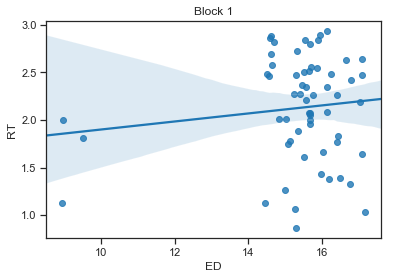

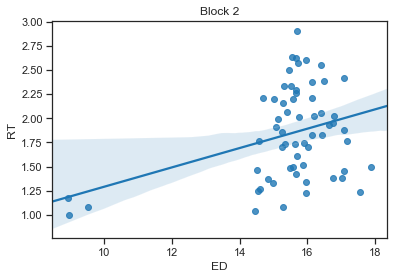

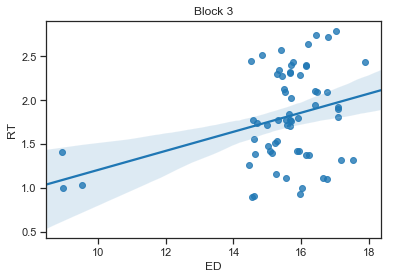

In [25]:
# Count number of non-response trials
print('\nThere are %i non-response trials' % len(test_df[test_df['Choice']==99]))

# Scatter plot the three blocks seperately
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=test_df[(test_df['Block']==block) & (test_df['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusion for example subject**
- This does not tell us much. If anything, it contradicts our intuition that ED should correlate more strongly with RT in the first Block than the other two.

- In general, the slope of the linear fit seems to be driven by the three outliers (i.e. the apples).

### All subjects

In [26]:
# concatinate dfs
df_concat = pd.concat(dfs)

# add task variable
df_concat['task'] = 'name'

In [27]:
# Validate

# the length
assert len(df_concat) == len(dfs[0]) * 32
# all subjects are there
np.unique(df_concat['sub'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

**Scatter plot RT and ED for the three blocks just as before**


There are 414 non-response trials


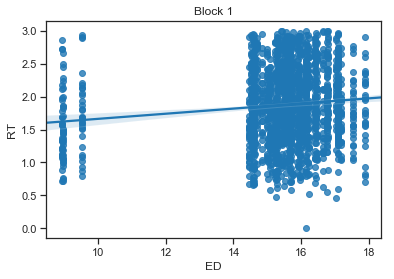

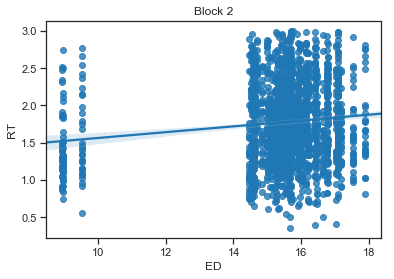

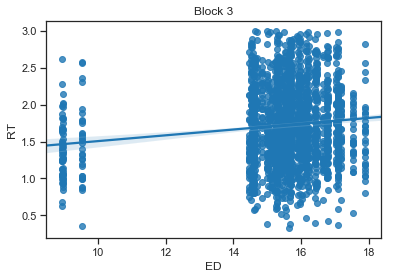

In [28]:
print('\nThere are %i non-response trials' % len(df_concat[df_concat['Choice']==99]))

for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=df_concat[(df_concat['Block']==block) & (df_concat['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Exclude ED outliers (the three weird apples)**

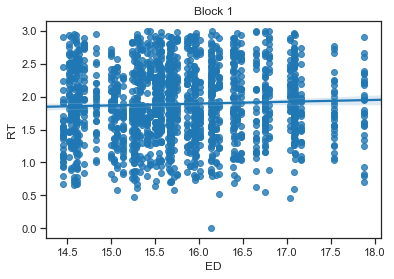

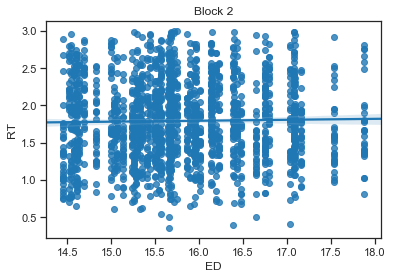

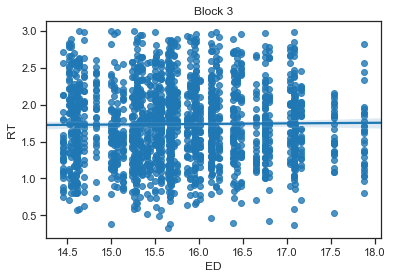

In [29]:
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=df_concat[(
                         df_concat['Block']==block) & (df_concat['Choice']!=99) & (df_concat['ED'] > 10)
                                   ])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions from explorative correlations with RT:**

There seems to be *no correlation* between ED and RT in any of the blocks when outliers are removed. This makes it unlikely that a prediction of RT by HMAX difference would be successfull.

However, These correlations do not inform the potential *learning*, which would reflect in changes of RT / accuracy across the experiment. This could only be investigated with a real *statistical model*, such as LMM, regression, ANCOVA, or others.

## Accuracy and ED

### Boxplot

In [30]:
# with outliers
# sns.boxplot(x='Answer', y='ED', data=df_concat[df_concat['Choice']!=99])

Again, remove ED outliers:

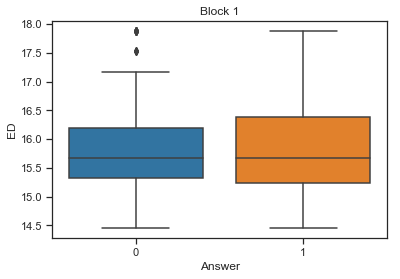

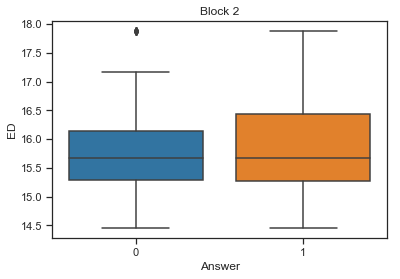

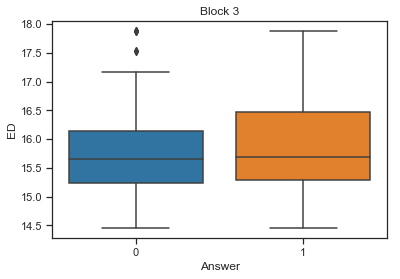

In [31]:
for block in range(3):
    sns.boxplot(x='Answer', y='ED',
                data=df_concat[ (df_concat['Choice']!=99) & (df_concat['ED']>10) & (df_concat['Block']==block)])
    plt.title('Block %i' % (block+1))
    plt.show()

### (Logistic) regression plot

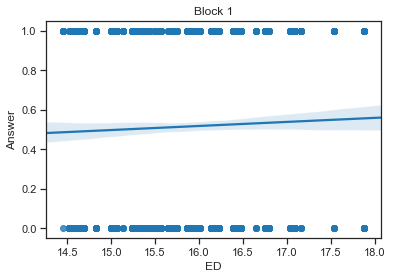

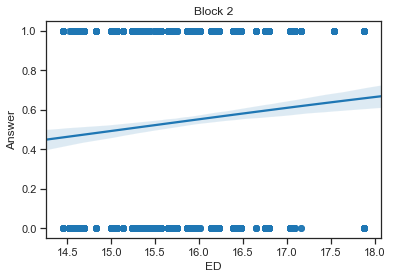

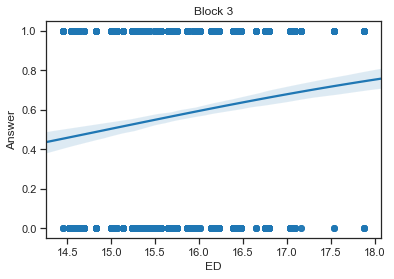

In [32]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=df_concat[ (df_concat['Choice'] != 99)
                               & (df_concat['ED'] > 10)
                               & (df_concat['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions explorative Accuracy analysis:**

Much like with reaction times, there does not seem to be much of a statistical relationship between HMAX difference and accuracies. The same reasoning holds that an iference analysis could yield an interaction between time (i.e. block) and ED, which would signal learning depends on loss of visual information. **The question is if this would be worth it.** Right now, it doesn't look very promising.

# Discrimination task

## Stimuli and Design of Experiment 2

Stimuli and design in Experiment 2 were the same as in Experiment 1 except that there were always 4 alternative choices across all blocks, and the time limit for accepting response was 3s. There was an additional post-test which took place one week later. The post-test consisted of a block of the naming task, and a block of the discrimination task, which was the same as the task during training. The order of the two blocks in the post-test was fixed in the way that the first block was always the same as the last block during training.

**Sidenote**: *Above chance accuracies (ACA)* were the main measure of performance in Lihui's analysis. There, she devided the average accuracy in each block by the chance level (which depended on the number of distractors). If we want to set up a trial-wise model, we cannot do that.

## Load discrimination task data

And add ED, subject number, as well as ACA

In [33]:
# sorted list of hdf files
disc_files = sorted(glob.glob(datadir+'/*Discrimination*'))
assert len(disc_files) == 32

# Read all files in pandas
disc_dfs = [pd.read_hdf(disc_file) for disc_file in disc_files]

# insert EDs
disc_dfs = [insert_eds(df, ed_dicts) for df in disc_dfs]

# iterate through dfs
for df, sub_num in zip(disc_dfs, range(1,len(disc_dfs)+1)):
    
    # add subject number
    df['sub'] = sub_num

    # compute and insert ACA
    for block in range(3):
        df.loc[df['Block'] == block,'ACA'] = np.mean(df.loc[df['Block'] == block, 'Answer'])
    
# concatinate into one data frame
disc_df = pd.concat(disc_dfs)

# add task variable
disc_df['task'] = 'disc'

In [34]:
disc_df.head()

,Img,ImgName,AlterImgs,Answer,Choice,RT,MousePos,Block,Trlnum,ED,sub,ACA,task
0,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.3_v2_percept.png, stim_set/Lo...",1,0,1.762020,"[-0.55625, -0.17222222222222222]",0,0,15.323762,1,0.734375,disc
1,stim_set/Zahnpasta.7_v2_percept.png,Zahnpasta,"[stim_set/Banane.1_v2_percept.png, stim_set/Gl...",0,99,0.000000,"[0.14479166666666668, -0.21481481481481482]",0,1,14.634605,1,0.734375,disc
2,stim_set/Banane.1_v2_percept.png,Banane,"[stim_set/Schere.4_v2_percept.png, stim_set/Ta...",0,1,1.705525,"[0.28958333333333336, -0.06851851851851852]",0,2,15.745837,1,0.734375,disc
3,stim_set/Loeffel.8_v2_percept.png,Löffel,"[stim_set/Banane.2_v2_percept.png, stim_set/Ta...",1,0,1.595861,"[-0.17708333333333334, -0.2833333333333333]",0,3,15.238930,1,0.734375,disc
4,stim_set/Loeffel.2_v2_percept.png,Löffel,"[stim_set/Apfel.8_v2_percept.png, stim_set/Ban...",1,0,1.622645,"[0.2125, -0.1685185185185185]",0,4,14.996077,1,0.734375,disc


## ACAs per block

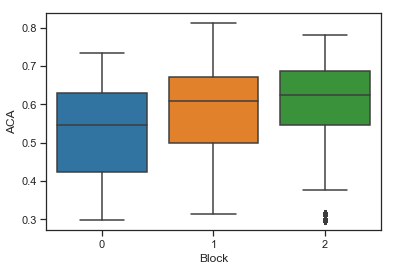

In [35]:
sns.boxplot(data=disc_df, x='Block', y='ACA')

## Logistic plot for Accuracy by ED for each block

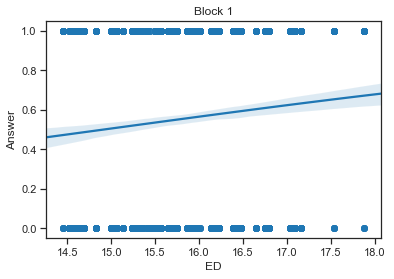

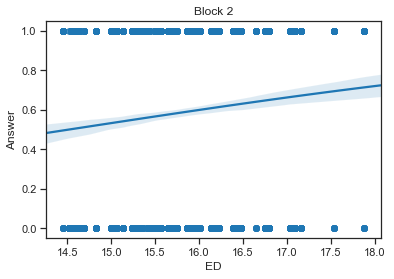

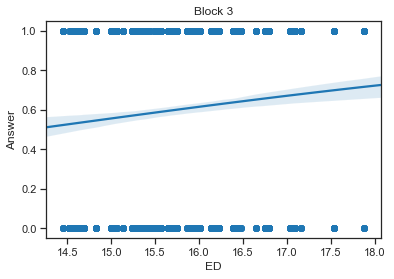

In [36]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=disc_df[ (disc_df['Choice'] != 99)
                               & (disc_df['ED'] > 10)
                               & (disc_df['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

## Reaction times by ED and block

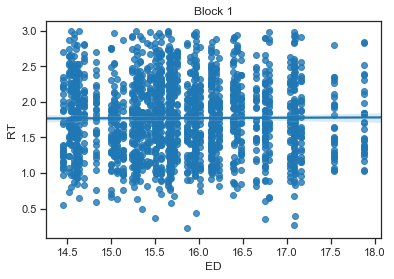

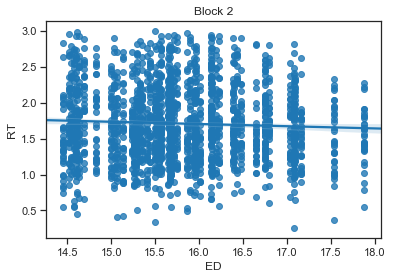

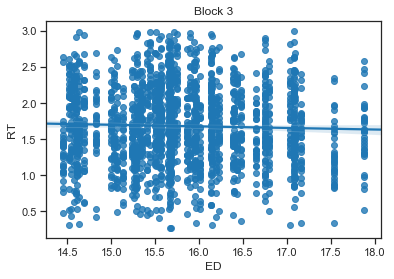

In [37]:
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=disc_df[(
                         disc_df['Block']==block) & (disc_df['Choice']!=99) & (disc_df['ED'] > 10)
                                   ])
    plt.title('Block %i' % (block+1))
    plt.show()